In [1]:
#Import and install required libraries
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
import numpy as np

!pip install wandb
import wandb
from wandb.keras import WandbCallback

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip and load file data file onto server, then delete zip file for optimizing performance
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip
!rm nature_12K.zip

In [2]:
## Automate the building of CNN
def createCNN(num_filters=32, filter_multiplier=1, dropout=0.2, batch_norm=False, dense_size=64, num_classes=10, image_size=200):
    model = Sequential()
    
    for i in range(5):
        filter_dim = 11 - 2*i
        filter_size = (filter_dim, filter_dim)
        if i==0:
            model.add(Conv2D(num_filters, filter_size, input_shape=(image_size, image_size, 3), data_format="channels_last"))
        else:
            model.add(Conv2D(num_filters, filter_size))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        num_filters = int(num_filters * filter_multiplier)
    
    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))
    model.add(Activation("relu"))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    return model

In [3]:
## Prepare the dataset for training
def prepare_dataset(DATA_DIR="inaturalist_12K", augment_data=False):
    train_dir = os.path.join(DATA_DIR, "train")
    test_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)

    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
        test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256, subset="training")
    val_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256, subset="validation")
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(200, 200), batch_size=256)
    
    return train_generator, val_generator, test_generator;

In [4]:
#Customise run names for WandB to enhance readability
def setRunName(num_filters=32, filter_multiplier=1, augment_data=False, dropout=0.2, batch_norm=False):
    
    augment_data_options = {True: "Y", False: "N"}
    batch_norm_options = {True: "Y", False: "N"}

    run_name = "_".join(["num", str(num_filters), "org", str(filter_multiplier), "aug", augment_data_options[augment_data],
                      "drop", str(dropout), "norm", batch_norm_options[batch_norm]])
    
    return run_name;

In [5]:
#Integrate WandB with training and validation process
def train():

    config_defaults = {
        "num_filters": 32,
        "filter_multiplier": 2,
        "augment_data": False,
        "dropout": 0.3,
        "batch_norm": False,
        "epochs": 10,
        "dense_size": 64,
        "lr": 0.001
    }

    wandb.init(config=config_defaults, magic=True)
    config = wandb.config
    wandb.run.name = setRunName(config.num_filters, config.filter_multiplier, config.augment_data, config.dropout, config.batch_norm)

    train_generator, val_generator, test_generator = prepare_dataset(augment_data=config.augment_data)
    model = createCNN(num_filters=config.num_filters, filter_multiplier=config.filter_multiplier,
                      dropout=config.dropout, batch_norm=config.batch_norm, dense_size=config.dense_size)
    model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback()])

In [6]:
#Prepare training and test generators for testing
def prepare_test_dataset(DATA_DIR="inaturalist_12K", augment_data=False, image_size=200):
    train_dir = os.path.join(DATA_DIR, "train")
    test_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)

    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=256)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=30)
    
    return train_generator, test_generator;

In [7]:
#Display sample test images with their predictions and labels
def plot_test_results(test_data, predictions, labels):
    fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(15,15))
    output_map = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 
                  5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}
    for i in range(30):
        img = test_data[0][0][i]
        ax[int(i/6), i%6].imshow(img)
        ax[int(i/6), i%6].axis('off')
        ax[int(i/6), i%6].set_aspect('equal')
        ax[int(i/6), i%6].set_title("Predicted: " + output_map[np.argmax(predictions, axis=1)[i]] + "\nLabel: " + output_map[np.argmax(labels, axis=1)[i]])

In [8]:
#Visualise feature maps from the first Conv layer for a test image
def plot_filters(model, test_data, sample_num):
    sub_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    plt.imshow(test_data[0][0][sample_num])
    plt.axis('off')
    feature_maps = sub_model(test_data[0][0])
    fig, ax = plt.subplots(4, 8, figsize=(12,6))
    for i in range(feature_maps.shape[-1]):
        ax[int(i/8), i%8].imshow(feature_maps[sample_num, :, :, i], cmap='gray')
        ax[int(i/8), i%8].axis('off')

In [9]:
#Integrate WandB with testing and evaluation process
def test():

    config_defaults = {
        "num_filters": 32,
        "filter_multiplier": 2,
        "augment_data": True,
        "dropout": 0.3,
        "batch_norm": True,
        "epochs": 10,
        "dense_size": 64,
        "lr": 0.001
    }

    wandb.init(config=config_defaults, magic=True)
    config = wandb.config
    wandb.run.name = setRunName(config.num_filters, config.filter_multiplier, config.augment_data, config.dropout, config.batch_norm)

    train_generator, test_generator = prepare_test_dataset(augment_data=config.augment_data, image_size=256)
    model = createCNN(num_filters=config.num_filters, filter_multiplier=config.filter_multiplier,
                      dropout=config.dropout, batch_norm=config.batch_norm, dense_size=config.dense_size, image_size=256)
    model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, callbacks=[WandbCallback()])

    print("Evaluating Model:")
    model.evaluate(test_generator, batch_size=256)
    predictions = model(test_generator[0][0])
    plot_test_results(test_generator, predictions, test_generator[0][1])
    sample_num = 11
    plot_filters(model, test_generator, sample_num)
    model.save("Best_model.h5")

In [ ]:
#Set up a sweep config
sweep_config = {
    "name": "Test and Save Best Model Again",
    "description": "Checking the performance of CNN on sample of test data",
    "metric": "Val Accuracy",
    "method": "grid",
    "project": "CS6910_Assignment2",
    "parameters": {
        "num_filters": {
            "values": [32]
        },
        "filter_multiplier": {
            "values": [2]
        },
        "augment_data": {
            "values": [True]
        },
        "dropout": {
            "values": [0.3]
        },
        "batch_norm": {
            "values": [True]
        },
        "epochs": {
            "values": [1]
        },
        "dense_size": {
            "values": [64]
        },
        "lr": {
            "values": [0.001]
        },
        "epochs": {
            "values": [10]
        }
    }
}

# creating the sweep
sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment2")

Create sweep with ID: mv1yr1pl
Sweep URL: https://wandb.ai/avyay/cs6910_assignment2/sweeps/mv1yr1pl


In [ ]:
wandb.agent(sweep_id, function=test)

wandb: Agent Starting Run: 8j452811 with config:
wandb: 	augment_data: True
wandb: 	batch_norm: True
wandb: 	dense_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_multiplier: 2
wandb: 	lr: 0.001
wandb: 	num_filters: 32


Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
40/40 [==============================] - 234s 6s/step - loss: 3.2148 - categorical_accuracy: 0.1047
Epoch 2/10
40/40 [==============================] - 233s 6s/step - loss: 2.3025 - categorical_accuracy: 0.1030
Epoch 3/10
40/40 [==============================] - 232s 6s/step - loss: 2.2995 - categorical_accuracy: 0.0928
Epoch 4/10
40/40 [==============================] - 232s 6s/step - loss: 2.2946 - categorical_accuracy: 0.1026
Epoch 5/10
40/40 [==============================] - 233s 6s/step - loss: 2.2931 - categorical_accuracy: 0.1151
Epoch 6/10
40/40 [==============================] - 232s 6s/step - loss: 2.2897 - categorical_accuracy: 0.1218
Epoch 7/10
40/40 [==============================] - 232s 6s/step - loss: 2.2773 - categorical_accuracy: 0.1243
Epoch 8/10
40/40 [==============================] - 233s 6s/step - loss: 2.2848 - categorical_accuracy: 0.1210
Epoch 9/10
40/40 [========

epoch,9
loss,2.26214
categorical_accuracy,0.13611
_runtime,2340
_timestamp,1618072141
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▂▁▁▁▁
categorical_accuracy,▂▂▁▃▄▅▅▆██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [20]:
train_generator, test_generator = prepare_test_dataset(image_size=256)

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [12]:
model = keras.models.load_model("Best_model.h5")

In [23]:
def guided_backprop(model_path, n_images):

    # loading the data and the model
    train_generator, test_generator = prepare_test_dataset(image_size=256)
    model = tf.keras.models.load_model(model_path)

    # take upto 5th convolutional layer
    model_upto_conv5 = tf.keras.models.Model([model.inputs],[model.get_layer("conv2d_4").output])

    # creating a custom gradient to track actual non-zero gradients
    @tf.custom_gradient
    def guidedRelU(x):
        def grad(dy):
            return tf.cast(dy>0, tf.float32) * tf.cast(x>0, tf.float32) * dy
        return tf.nn.relu(x), grad

    for layer in model.layers[1:]:
        if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
            layer.activation = guidedRelU

    # plotting the images
    fig, axs = plt.subplots(n_images, 2, figsize=(2*4, n_images*4))
    inputs = tf.convert_to_tensor(test_generator[0][0][:n_images], dtype=tf.float32)

    for i in range(n_images):

        with tf.GradientTape() as tape:
            input = tf.expand_dims(inputs[i], 0)
            tape.watch(input)
            output = model_upto_conv5(input)[0]
        
        gradients = tape.gradient(output,input)[0]

        axs[i][0].set_title("Original Image")
        axs[i][0].imshow(inputs[i])
        axs[i][1].set_title("Guided backpropagation")
        axs[i][1].imshow(gradients)

    plt.show()

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

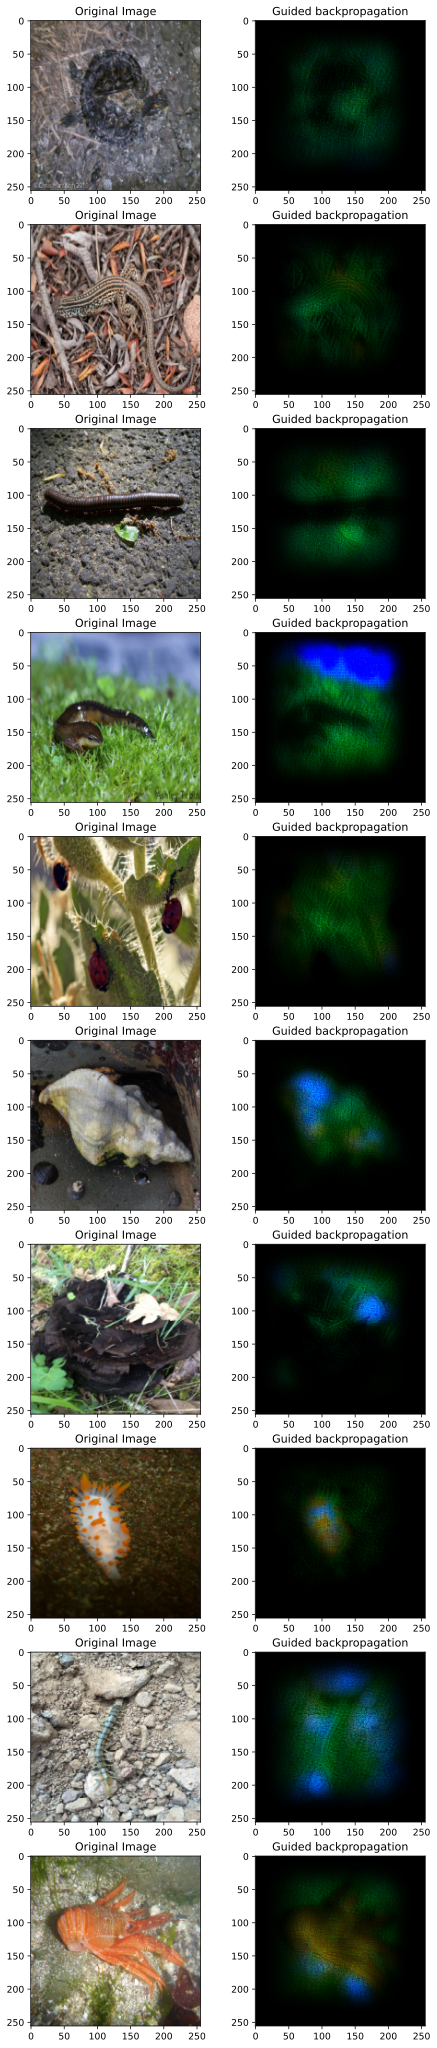

In [26]:
guided_backprop("Best_model.h5", 10)